In [60]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
def f(x):
  return 3*x**2 - 4*x +5
  

In [41]:
f(3.0)

20.0

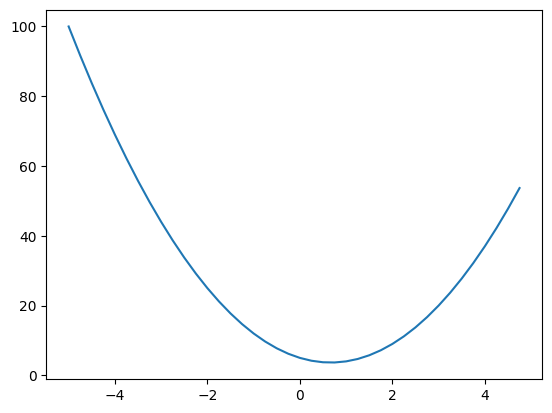

In [42]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [43]:
h=0.00000001
# x = 2/3 give slope 0
x = 3.0
(f(x+h) - f(x))/h # 1st derivative, f'(x) at x=3.0, slope of tangent line

14.00000009255109

In [44]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

#expressions
d1 = a*b + c
# a += h to find d d2 / da 
# b += h to find d d2 / db
c += h # to find d d2 / dc
d2 = a*b + c

print('d1', d1) #initial d1 value
print('d2', d2) # d2 is d1 after bumping a/b/c by h
print('slope', (d2-d1)/h) # slope, first derivative

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [123]:
class Value:
  def __init__(self, data, _children=(), _op='',label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda : None
    self.grad = 0.0
  def __repr__(self):
    return f'value(data={self.data})'
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward # attach backward function to out object, so we can call it later
    # can also use any variable to store this function and call it later
    # like out._back = _backward, and then call it out._back()
    return out
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v in visited:
        return
      visited.add(v)
      for child in v._prev:
        build_topo(child)
      topo.append(v)

    build_topo(self)
    self.grad = 1.0
    
    for node in reversed(topo):
      node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e  + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L

value(data=-8.0)

In [46]:
d._prev
# _children is a set of all the values that were used to compute d; children inputs

{value(data=-6.0), value(data=10.0)}

In [47]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

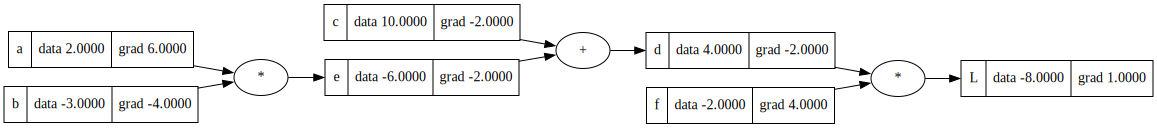

In [55]:
draw_dot(L)

In [54]:
L.grad = 1.0 # because dL/dL = 1

#*
# d.grad = -2.0 # because L = d*f, dL/d(d) = f i.e.(f.data)
d.grad = f.data
# f.grad = 4.0 # because L = d*f, dL/df = d i.e.(d.data)
f.grad = d.data
# for * gradient is value of sibling child node

#+
# e.grad = -2.0 # because d = e+c, and by chain rule dL/de = dL/dd * dd/de = -2 * 1 = -2 ... d=e+c, hence dd/de = 1 
e.grad = d.grad
# c.grad = -2.0 # because d = e+c, and dL/dc = dL/dd * dd/dc = -2 * 1 = -2 ... d=e+c, hence dd/dc = 1
c.grad = d.grad
# for + gradients for both children are equal to parent

#* in this case local gradient is value of sibling child node and gradient is local gradient * gradient of parent node, because of the chain rule
# a.grad = -2.0 * -3.0
a.grad = b.data * e.grad
# b.grad = -2.0 * 2.0
b.grad = a.data * e.grad


In [50]:
# to check grads of each node
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()


-3.9999999999995595


In [51]:
# bumping leaf node values in the direction of their gradients

a.data += a.grad * 0.01
b.data += b.grad * 0.01
c.data += c.grad * 0.01
f.data += f.grad * 0.01

e = a*b
d = e + c
L = d * f

L.data # it has decreased due to influence of change (increase) in leaf node values

-7.286496

In [124]:
# backpropogation of neuron
# it is a linear combination of inputs with weights and then passed through an activation function
# summition of inputs * weights + bias = n
# activation function = sigmoid(n) or tanh(n) .. this is the output of the neuron

# backpropogation is the process of calculating the gradients of the loss function with respect to the weights and biases of the neuron

# inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b = n
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



In [105]:
o.grad = 1.0
o._backward()
n._backward()
b._backward() # bias is a leaf node, so it has no _prev, hence no _backward, i.e. nothing will happen
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()



In [110]:
# to apply _backward to all nodes in the graph
# we are taking topological sort of the graph and then applying _backward to all nodes in the graph in reverse order
# topological sort is a linear ordering of the nodes in a graph such that for every directed edge uv from node u to node v, u comes before v in the ordering, left to right in the graph

o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
  if v in visited:
    return
  visited.add(v)
  for child in v._prev:
    build_topo(child)
  topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()


In [125]:
o.backward() # this is the same as above, but it is a method of Value class

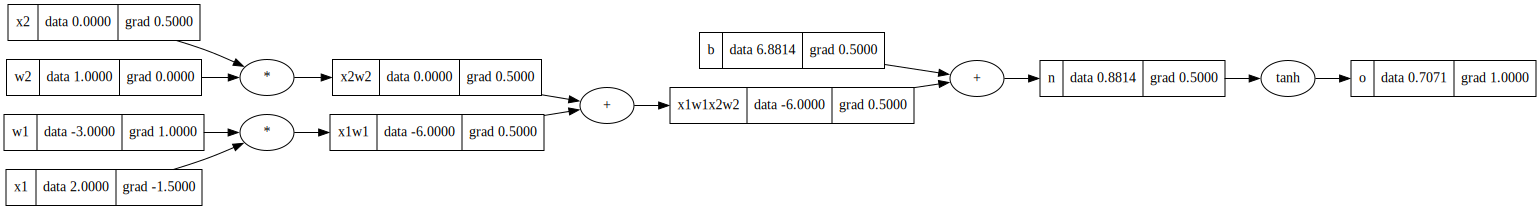

In [126]:
draw_dot(o)

In [84]:
# manual backpropogation

o.grad = 1.0

# tanh
n.grad = 0.5 
# n.grad = 1 - o.data**2      # 0.4999999
# as o = tanh(n) 
# and by the formula of tanh derivative
#  do/dn = 1 - tanh(n)^2
#  i.e. do/dn = 1 - o**2

# +
b.grad = 0.5
x1w1x2w2.grad = 0.5

# +
x1w1.grad = 0.5
x2w2.grad = 0.5

# *
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

# *
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
